## 00: Set Up

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [5]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## 01: Prepare Data

FIrst download and read the daily-min-temperature data as numpy arrays for later processing.

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-08-19 16:00:06--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2020-08-19 16:00:07 (3.72 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



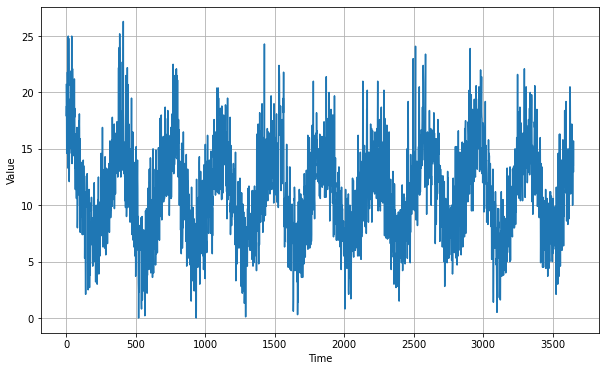

In [7]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile,delimiter=',')
  next(reader)
  step = 0
  for row in reader:
    step = step + 1
    time_step.append(step)
    temps.append(float(row[1]))

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

Then define the training and validation datasets.

In [8]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda x: (x[:-1],x[1:]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [ ]:
tf.random.set_seed(51)
np.random.seed(51)
window_size = 60
batch_size = 100
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## 02: Build Model

We build a neural network with both convolution and LSTM layers. Like last blog we can train with different leearning rates to select the best one, here we got 1e-5.

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(32,5,1,padding='causal',activation='relu',input_shape=[None,1]),
  tf.keras.layers.LSTM(64,return_sequences=True),
  tf.keras.layers.LSTM(64,return_sequences=True),
  tf.keras.layers.Dense(30,activation='relu'),
  tf.keras.layers.Dense(10,activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 20)

])

model.summary()


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
____________________

## 03: Train the model

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=200)                                    

    Epoch 1/200
    25/25 [==============================] - 0s 15ms/step - loss: 9.2188 - mae: 9.7166
    Epoch 2/200
    25/25 [==============================] - 0s 14ms/step - loss: 3.6602 - mae: 4.1325
    Epoch 3/200
    25/25 [==============================] - 0s 14ms/step - loss: 2.5666 - mae: 3.0272
    Epoch 4/200
    25/25 [==============================] - 0s 13ms/step - loss: 2.3931 - mae: 2.8506
    Epoch 5/200
    25/25 [==============================] - 0s 13ms/step - loss: 2.3044 - mae: 2.7591
    ......
    Epoch 196/200
    25/25 [==============================] - 0s 14ms/step - loss: 1.6188 - mae: 2.0651
    Epoch 197/200
    25/25 [==============================] - 0s 14ms/step - loss: 1.6177 - mae: 2.0641
    Epoch 198/200
    25/25 [==============================] - 0s 13ms/step - loss: 1.6167 - mae: 2.0629
    Epoch 199/200
    25/25 [==============================] - 0s 14ms/step - loss: 1.6155 - mae: 2.0617
    Epoch 200/200
    25/25 [==============================] - 0s 14ms/step - loss: 1.6146 - mae: 2.0607

## 04: Use the model

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [19]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

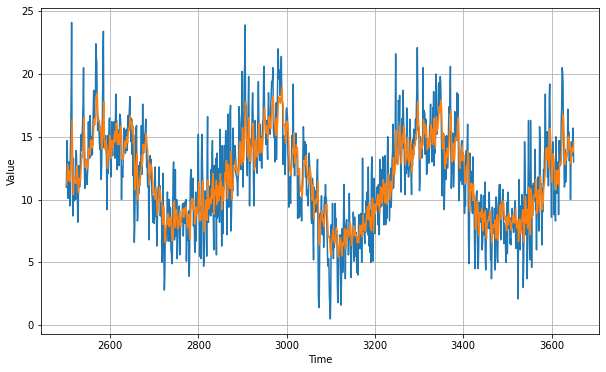

In [22]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.835204

In [24]:
print(rnn_forecast)

[11.162854 11.376381 11.969067 ... 13.939636 13.815279 14.576508]


We can see that the model works pretty well.